## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

### Устанавливаем первую часть библиотек. Здесь немного больше, чем нужно, но лучше перестраховаться

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
from random import randint

cuda


#### Функция для того, чтобы выводить подробную информацию о модели

In [0]:
def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")       


#### Мой генератор, взятый из задания из сегментации с небольшими изменениями

In [0]:
# модель похожа на эту https://iopscience.iop.org/article/10.1088/1742-6596/1345/5/052066/pdf но с меньшим числом dilated сверток (т.к. размер картинки меньше)
class DilatedUNet_Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels=32,
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True)

        )
        self.pool0 = nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=1, dilation=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 32,
                      out_channels = 48,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(48),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels = 48,
                      out_channels = 64,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True)
        )
        self.pool1 = nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=1, dilation=2)# 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64,
                      out_channels = 96,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels = 96,
                      out_channels = 128,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True)
        )

        self.pool2 = nn.Conv2d(128, 128, kernel_size=2, stride=2, padding=1, dilation=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128,
                      out_channels = 176,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(176),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels = 176,
                      out_channels = 256,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True)
        )
        self.pool3 = nn.Conv2d(256, 256, kernel_size=2, stride=2, padding=1, dilation=2) # 32 -> 16

        # dilation
        self.dilated_conv0 = nn.Sequential( 
            nn.Conv2d(256, out_channels=256, kernel_size=3, dilation=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256)
        )
        self.dilated_conv1 =  nn.Sequential(  
            nn.Conv2d(256, out_channels=256, kernel_size=3, dilation=2,  padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
        )
        self.dilated_conv2 = nn.Sequential(
            nn.Conv2d(256, out_channels=256, kernel_size=3, dilation=4,  padding=4),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True)
        )
        self.dilated_conv3 = nn.Sequential(
            nn.Conv2d(256, out_channels=256, kernel_size=3, dilation=8,  padding=8),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True)
        )
       
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d( 256, 256, kernel_size = 2, stride = 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels = 512,
                      out_channels = 256,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels = 256,
                      out_channels = 128,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True)
        ) 
        self.upsample1 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2,  padding=1, dilation=2, output_padding=1)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 256,
                      out_channels = 128,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels = 128,
                      out_channels = 64,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True)
        ) 
        self.upsample2 = nn.ConvTranspose2d( 64, 64, kernel_size = 2, stride = 2,  padding=1, dilation=2, output_padding=1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 128,
                      out_channels = 64,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels = 64,
                      out_channels = 32,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True)
        ) 
        self.upsample3 = nn.ConvTranspose2d(32, 32, kernel_size = 2, stride = 2,  padding=1, dilation=2, output_padding=1) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 64,
                      out_channels = 32,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels = 32,
                      out_channels = 32,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels = 32,
                      out_channels = 16,
                      kernel_size = 3,
                      padding = 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels = 16,
                      out_channels = 3,
                      kernel_size = 3,
                      padding = 1)

        ) 

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))
        # bottleneck
        dilated0 = self.dilated_conv0(e3)
        dilated1 = self.dilated_conv1(dilated0)
        dilated2 = self.dilated_conv2(dilated1)
        dilated3 = self.dilated_conv3(dilated2)

        b = dilated0 + dilated1 + dilated2 + dilated3
        
        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), self.enc_conv3(e2)), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), self.enc_conv2(e1)), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), self.enc_conv1(e0)), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), self.enc_conv0(x)), dim=1)) # no activation
        
        
        return torch.tanh(d3)

#### Мой дискриминатор - очень простая сеть для классификации

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
        super().__init__()
        self.inp = nn.Conv2d(6, 16, kernel_size=2, stride=2, padding=1)
        self.conv1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 1, kernel_size=2),
            nn.Sigmoid()
        )

  def forward(self, generated, real):
      concatenated = torch.cat([generated, real], dim=1)
      x = self.inp(concatenated)
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      res = self.conv4(x)
      return res


##### Функция для того, чтобы настраивать обучаемость слоев в модели

In [0]:
def set_trainability(model, trainability=False):
  for param in model.parameters():
    param.requires_grad = trainability

#### Функция для обучения модели. Принимает 2 модели (генератор и дискриминатор, оптимизаторы для них, scheduler и параметры для обучения

In [0]:
def train(generator, discriminator, dataloader, opt1, opt2, scheduler, n_epoches=100, l1_lambda=25):
  history = {}
  generator.to(device)
  discriminator.to(device)
  loss_bce = nn.BCELoss()
  loss_l1 = nn.L1Loss()
  history['generator_loss'] = []
  history['discriminator_loss'] = []
  for epoch in range(n_epoches):
    losses1 = []
    losses2 = []
    for batch in dataloader:
      running_loss_d = 0
      running_loss_g = 0
      X = batch['X']
      Y = batch['Y']
      X = Variable(X.to(device))
      Y = Variable(Y.to(device))
      discriminator.zero_grad()
      set_trainability(discriminator, True)
      set_trainability(generator, False)

      real_res = discriminator(X, Y)

      fake_img = generator(X)

      fake_res = discriminator(X, fake_img)


      REAL = Variable(torch.ones(real_res.size())).to(device)

      FAKE = Variable(torch.ones(fake_res.size())).to(device)


      real_val_loss = loss_bce(real_res, REAL)
      fake_val_loss = loss_bce(fake_res, FAKE)
      # эта модель проще, поэтому учится быстрее, надо ее замедлить
      running_loss_d = (real_val_loss + fake_val_loss) * 0.5
      running_loss_d.backward()
      opt2.step()
      # training generator
      set_trainability(discriminator, False)
      set_trainability(generator, True)

      generator.zero_grad()
      fake_img = generator(X)

      fake_res = discriminator(X, fake_img)
      similarity = loss_l1(fake_img, Y)
      fooling = loss_bce(fake_res, REAL)
      # здесь все же ошибку дескриминатора увеличим
      running_loss_g = l1_lambda * similarity + fooling * 4
      running_loss_g.backward()
     
      opt1.step()
      losses1.append(running_loss_g)
      losses2.append(running_loss_d)
      torch.cuda.empty_cache()
          
    scheduler.step()
    clear_output(wait=True)
    rnd_ind = randint(0, len(fake_img)-1)
    print('Epoch: %d, generator loss :%.3f, discriminator loss: %.3f' % (epoch, running_loss_g ,running_loss_d))
    img_to_show = np.array(Y[rnd_ind].detach().cpu().numpy()).clip(0,1)
    fig=plt.figure(figsize=(10, 5))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img_to_show.transpose((1, 2, 0)))
    img_to_show = np.array(fake_img[rnd_ind].detach().cpu().numpy()).clip(0,1)
    fig.add_subplot(1, 2, 2)
    plt.imshow(img_to_show.transpose((1, 2, 0)))
    plt.show(block=True)
        
    history['generator_loss'].append(sum(losses1)/len(losses1))
    history['discriminator_loss'].append(sum(losses2)/len(losses2))
    
  return history
    
   


    

      



    


#### Сбор данных для того, чтобы решить уже существующую задачу - отрисовку фасадов зданий

In [0]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2246, done.
remote: Total 2246 (delta 0), reused 0 (delta 0), pack-reused 2246
Receiving objects: 100% (2246/2246), 8.04 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (1456/1456), done.


In [0]:
!pip install -r requirements.txt

     |████████████████████████████████| 686kB 6.5MB/s 
     |████████████████████████████████| 204kB 19.9MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655250 sha256=b33ad4891cee29e0c799190adafe665cc16784c260b5f318c831dec08b93f280
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5712 sha256=c99f61424e93fc3a30b1eb4639490be9a9d9f35967911b97f5845ad8652b6759
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


In [0]:
!bash ./datasets/download_pix2pix_dataset.sh facades


Specified [facades]
for details.

--2020-05-31 07:44:04--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘./datasets/facades.tar.gz’

./datasets/facades. 100%[===================>]  28.77M  1.26MB/s    in 18s     

2020-05-31 07:44:22 (1.63 MB/s) - ‘./datasets/facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.

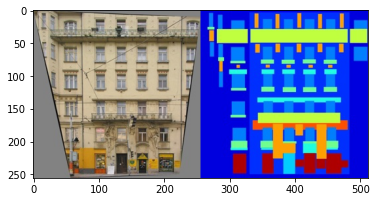

In [0]:
import matplotlib.pyplot as plt

img = plt.imread('/content/pytorch-CycleGAN-and-pix2pix/datasets/facades/train/301.jpg')
plt.imshow(img)

##### Установка необходимых для работы с датасетом библиотек

In [0]:
import pickle
import numpy as np

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from pathlib import Path

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors, pyplot as plt
%matplotlib inline

#### Датасет с фасадами зданий

In [0]:
RESCALE_SIZE = 256
class Facedes(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, data):
        super().__init__()
        # список файлов для загрузки
        self.data = sorted(data)




        self.len_ = len(self.data)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file1):
        image1 = Image.open(file1)
        image1.load()
        return image1.resize((RESCALE_SIZE*2, RESCALE_SIZE)) 
                
  
    def __getitem__(self, index):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.data[index])
        x = transform(x)
        x = 0.01*torch.randn(x.shape) * x + 0.99*(x)
        y = x[:, :, 0:RESCALE_SIZE]
        x = x[:, :, RESCALE_SIZE:]
        return {'X':x, 'Y':y}
        


##### Функция для отображения картинок

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

##### Сборка датасета и даталоадеров

In [0]:
TRAIN_DIR = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/facades/train/')

In [0]:
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [0]:
dataset = Facedes(train_files)

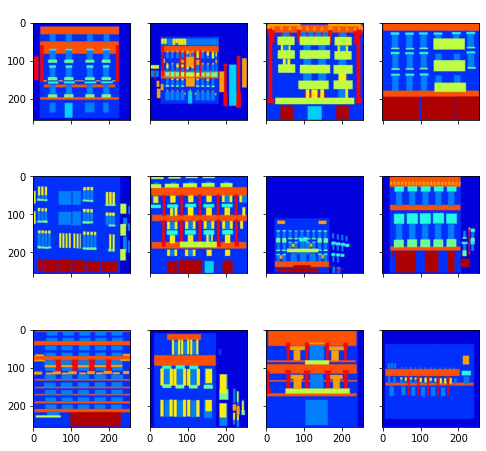

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=4,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_img = int(np.random.uniform(0,256))
    first = dataset[random_img]
    img_label = " "
    imshow(first['X'].data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [0]:
BS = 16
dataloader = DataLoader(dataset, batch_size=BS)

#### Основной цикл обучения

In [0]:
gen = DilatedUNet_Generator()
disc = Discriminator()
opt1 = torch.optim.AdamW(gen.parameters(), lr=5e-4)
opt2 = torch.optim.SGD(disc.parameters(), lr=1e-4, momentum=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt2, step_size=5, gamma=0.8, last_epoch=-1)

Epoch: 99, generator loss :24.287, discriminator loss: 0.111


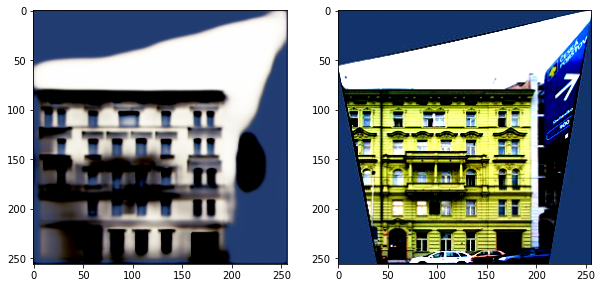

In [0]:
hist = train(gen, disc, dataloader, opt1, opt2, scheduler, 100, l1_lambda=50)

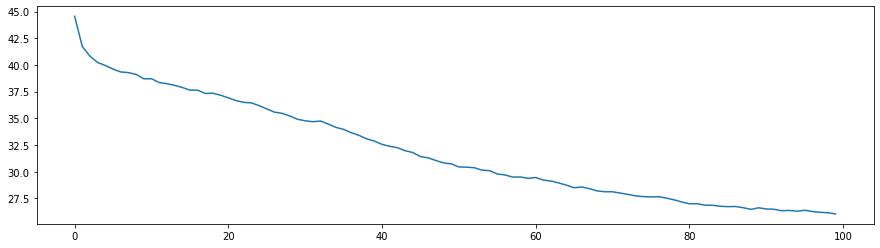

In [0]:

plt.plot(hist['generator_loss'])

##### Сохранение весов моделей

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import copy
model_weights = copy.deepcopy(gen.state_dict())
torch.save(model_weights, "/content/gdrive/My Drive/simpsons/generator_weights.pth") 

In [0]:
model_weights = copy.deepcopy(disc.state_dict())
torch.save(model_weights, "/content/gdrive/My Drive/simpsons/discriminator_weights.pth") 

### Работа со своей задачей - восстановление утерянных частей на портретных фото

#### Скачивание данных - датасет с фото

In [0]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daniilorel","key":"8e907a9f5c9a658d053ef047555510e2"}'}

In [0]:
!pip uninstall -q kaggle==1.5.6
!pip install -q kaggle==1.5.6
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /content/kaggle.json  # set permission

Proceed (y/n)? y
kaggle.json


In [0]:
!ls

gdrive	kaggle.json  sample_data


In [0]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection -p /content/gdrive/My\ Drive/faces/data

real-and-fake-face-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip -q /content/gdrive/My\ Drive/faces/data/real-and-fake-face-detection.zip

In [0]:
TRAIN_DIR = Path('/content/real_and_fake_face/training_real')

In [0]:
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [0]:
train_files

[PosixPath('/content/real_and_fake_face/training_real/real_00001.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00002.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00003.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00004.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00005.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00006.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00007.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00008.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00009.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00010.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00011.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00012.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00013.jpg'),
 PosixPath('/content/real_and_fake_face/training_real/real_00014

#### Создание немного испорченной версии фото - утеряна небольшая часть + добавлены шумы

In [0]:
import cv2
def create_x(x, cutting=False, blur=False):
        c, h, w = x.shape
        x = x.detach().numpy()
        x = x.transpose((1, 2, 0))
        if blur:
          karnel_size = np.random.randint(2, 4)
          #x = cv2.fromarray(x)
          x = cv2.blur(x,(karnel_size, karnel_size))

        if cutting:
          while True:
              deleted_area = np.random.uniform(0.05, 0.1) * h * w
              deleted_ratio = np.random.uniform(0.1, 0.5)
              new_w = int(np.sqrt(deleted_area / deleted_ratio))
              new_h = int(np.sqrt(deleted_area * deleted_ratio))
              left = np.random.randint(0, w)
              top = np.random.randint(0, h)

              if left +new_w <= w and top + new_h <= h:
                  break  
          noise = np.random.uniform(1, 255, (new_h, new_w, c))
          #print(x[:, top:top + new_h, left:left + new_w].shape, noise.shape)
          x[top:top + new_h, left:left + new_w, :] = noise
          x = x.transpose((2, 0, 1))
        return torch.Tensor(x)

#### Датасет

In [0]:
RESCALE_SIZE = 256
class Faces(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, data, cutting=False, blur=False):
        super().__init__()
        # список файлов для загрузки
        self.data = sorted(data)
        self.cutting = cutting
        self.blur = blur



        self.len_ = len(self.data)
                      
    def __len__(self):
        return self.len_
      
      
    def load_sample(self, file1):
        image1 = Image.open(file1)
        image1.load()
        return image1.resize((RESCALE_SIZE, RESCALE_SIZE)) 
                
  
    def __getitem__(self, index):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        y = self.load_sample(self.data[index])
        y = transform(y)
        x = create_x(y, self.cutting, self.blur)
        return {'X':x, 'Y':y}


In [0]:
dataset = Faces(train_files, True, True)

##### Вот что случается с изображениями после обработки описанной выше функцией

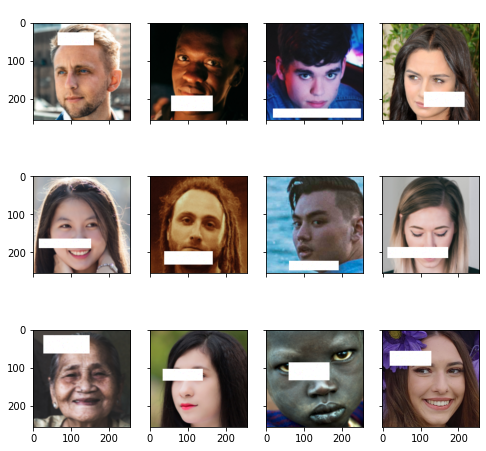

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=4,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_img = int(np.random.uniform(0,len(dataset)))
    first = dataset[random_img]
    img_label = " "
    imshow(first['X'].data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [0]:
BS = 16
dataloader = DataLoader(dataset, batch_size=BS)

#### Цикл обучения

In [0]:
gen = DilatedUNet_Generator()
disc = Discriminator()
opt1 = torch.optim.AdamW(gen.parameters(), lr=5e-4)
opt2 = torch.optim.SGD(disc.parameters(), lr=5e-5, momentum=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt2, step_size=2, gamma=0.85, last_epoch=-1)

Epoch: 149, generator loss :45.179, discriminator loss: 0.371


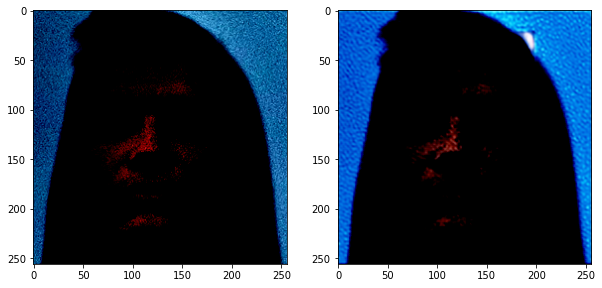

In [0]:
hist = train(gen, disc, dataloader, opt1, opt2, scheduler, 150, l1_lambda=100)

##### Видно, что генератор очень хорошо обучился, но можно и продолжить его обучение

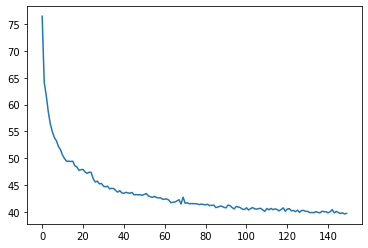

In [0]:
plt.plot(hist['generator_loss'])

#### Сохранение весов

In [0]:
import copy
model_weights = copy.deepcopy(gen.state_dict())
torch.save(model_weights, "/content/gdrive/My Drive/simpsons/faces_generator_weights.pth") 
model_weights = copy.deepcopy(disc.state_dict())
torch.save(model_weights, "/content/gdrive/My Drive/simpsons/faces_discriminator_weights.pth") 